# Yelp Review Rating Recommender

### by Bailey Blum, Molly Giglia, Horacio Lopez & Ale Lopez

# Section 1

This section loads the initial data file "reviews.json" into memory. It performs data preprocessing, and condenses our data into 5000 reviews per star class. It chooses the reviews that are in the third quartile of length (50%-75%). 

This code will take a VERY VERY long time to run, so DO NOT run it! Section 2 is where our actual model training and evaluation happens.

In [1]:
import json
import pandas as pd
    

with open('yelp_dataset/review.json') as json_file:      
    data = json_file.readlines()
    # this line below may take at least 8-10 minutes of processing for 4-5 million rows. It converts all strings in list to actual json objects. 
    data = list(map(json.loads, data)) 

In [2]:
texts = [d['text'] for d in data]
stars = [d['stars'] for d in data]

In [3]:
from collections import Counter

freqs = Counter(stars)

# the least common class is the maximum number we want for all classes
max_allowable = 5000
#max_allowable = freqs.most_common()[-1][1]
num_added = {clss: 0 for clss in freqs.keys()}
new_stars = []
new_texts = []
total = 0
counter = 0

for i, y in enumerate(stars):
    total += len(texts[i])
    counter += 1

avg = total / counter #this calculates the average length of the reviews.

 
def balance_classes(texts, stars):

    freqs = Counter(stars)

    # the least common class is the maximum number we want for all classes
    max_allowable = 5000
    #max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_stars = []
    new_texts = []
    for i, y in enumerate(stars):
        if len(texts[i]) < avg*1.5 and len(texts[i]) > avg: #only includes reviews in the third quartile. 
            if num_added[y] < max_allowable:
                new_stars.append(y)
                new_texts.append(texts[i])
                num_added[y] += 1
    return new_texts, new_stars

In [4]:
#print(Counter(stars))
balanced_x, balanced_y = balance_classes(texts, stars)
print(Counter(balanced_y))
#print(balanced_y[:10])

Counter({5.0: 5000, 4.0: 5000, 3.0: 5000, 1.0: 5000, 2.0: 5000})


In [5]:
import os
os.remove("texts.txt")
os.remove("stars.txt")
f = open("texts.txt", "w")
f2 = open("stars.txt", "w")
for item in balanced_x:
    f.write(item + "Gigliablurb") #will be used as a unique identifier to split our reviews later.
for item in balanced_y:
    f2.write(str(int(item)) + '\n')
f.close()
f2.close()

# Section 2

This section is where the actual training of our models and analysis happens. Run from here down!

In [10]:
import json
import pandas as pd
import numpy as np
from collections import Counter
from pylab import *

f = open("texts.txt", "r")
f2 = open("stars.txt", "r")

balanced_x = []
balanced_y = []
listOfLines = f.read().split('Gigliablurb') #acts as a unique identifier to split our reviews. 
for item in listOfLines:
    balanced_x.append(item)
for item in f2.readlines():
    balanced_y.append(item)
    
f.close()
f2.close()

balanced_x = balanced_x[:-1]
print(len(balanced_x))

25000


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime
 
# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words="english")
t1 = datetime.datetime.now()
 
# the 'fit' builds up the vocabulary from all the reviews
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = vectorizer.fit_transform(balanced_x)
print(datetime.datetime.now() - t1)

0:00:09.851883


In [12]:
feature_names = vectorizer.get_feature_names()

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, balanced_y, test_size=0.20, random_state=42) #performs our train test split.

In [14]:
## from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#Model Classifications

# initialise the Naive-Bayes classifier
# classifier = MultinomialNB()
# classifier = ComplementNB()
#classifier = LinearSVC()
# classifier = tree.DecisionTreeClassifier(max_depth=15)
# classifier = RandomForestClassifier(n_estimators=100)
# classifier = AdaBoostClassifier(n_estimators=10) #takes 7.5 mins
classifier = LogisticRegression()

#Run it
t1 = datetime.datetime.now()
#X_train = X_train.toarray()
classifier.fit(X_train, y_train)
print(datetime.datetime.now() - t1)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0:00:05.695384


In [15]:
preds = classifier.predict(X_test) #show sample predictions vs actual results.
print(list(preds[:10]))
print(y_test[:10])

['5\n', '4\n', '2\n', '4\n', '5\n', '1\n', '2\n', '5\n', '4\n', '4\n']
['5\n', '2\n', '1\n', '4\n', '4\n', '1\n', '1\n', '4\n', '2\n', '5\n']


### Accuracy Score

In [16]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, preds))


0.5584


### Precision, Recall, F1

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          1
       0.64      0.76      0.70       976
          2
       0.50      0.43      0.46      1003
          3
       0.48      0.40      0.44       996
          4
       0.49      0.50      0.50      1008
          5
       0.65      0.69      0.67      1017

    accuracy                           0.56      5000
   macro avg       0.55      0.56      0.55      5000
weighted avg       0.55      0.56      0.55      5000



### Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, preds))

[[746 171  25  10  24]
 [269 433 202  51  48]
 [ 77 211 399 241  68]
 [ 34  46 181 508 239]
 [ 44   9  26 232 706]]


In [19]:
# # only for trees --> feature importance

# importances = classifier.feature_importances_
# indices = np.argsort(importances)[::-1]
# # Print the feature ranking
# print("Feature ranking:")

# for f in range(20):
#     print(feature_names[indices[f]])

### ROC Curve

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
new_y_test = []
for rating in y_test:
    if rating == '5\n':
        new_y_test.append([0,0,0,0,1])
    elif rating == '4\n':
        new_y_test.append([0,0,0,1,0])
    elif rating == '3\n':
        new_y_test.append([0,0,1,0,0])
    elif rating == '2\n':
        new_y_test.append([0,1,0,0,0])
    elif rating == '1\n':
        new_y_test.append([1,0,0,0,0])
new_y_test = np.array(new_y_test)
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(new_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(new_y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

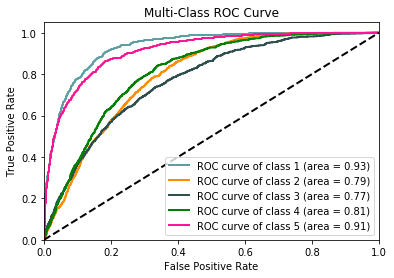

In [21]:
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['cadetblue', 'darkorange', 'darkslategray', 'green', 'deeppink'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Feature Analysis

In [22]:
tf = []
bf = []

def plot_coefficients(classifier, feature_names, top_features=20):

    # Access the coefficients from classifier
    coef = classifier.coef_

    # Access the classes
    classes = classifier.classes_

    # Iterate the loop for number of classes
    for i in range(len(classes)):
        print(classes[i])

        class_coef = coef[i]
        feature_names = np.array(feature_names)
        top_positive_coefficients = np.argsort(class_coef)[-top_features:]
        top_negative_coefficients = np.argsort(class_coef)[:top_features]
        tf.append(feature_names[np.array(top_positive_coefficients)])
        bf.append(feature_names[np.array(top_negative_coefficients)])
        
        top_coefficients = np.hstack([top_negative_coefficients, 
                                      top_positive_coefficients])
        plt.figure(figsize=(10, 3))

        colors = ["red" if c < 0 else "blue" for c in class_coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), class_coef[top_coefficients], color=colors)
       

        plt.xticks(np.arange(0, 1 + 2 * top_features), 
                   feature_names[top_coefficients], rotation=60, ha="right")
        plt.show()

1



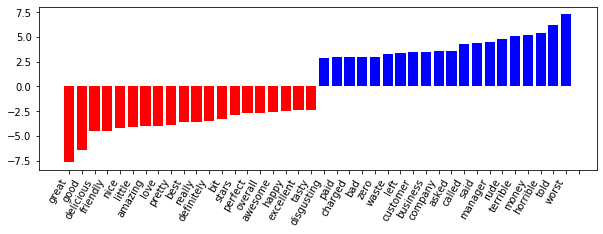

2



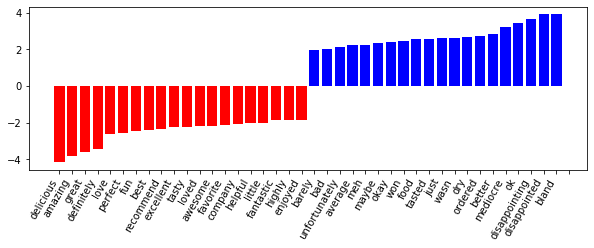

3



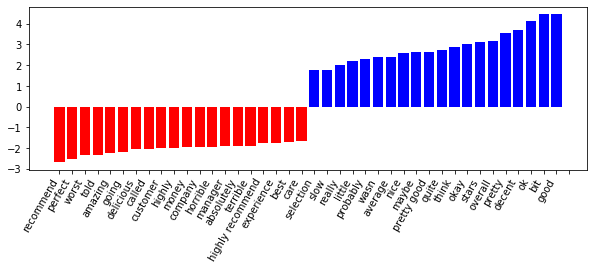

4



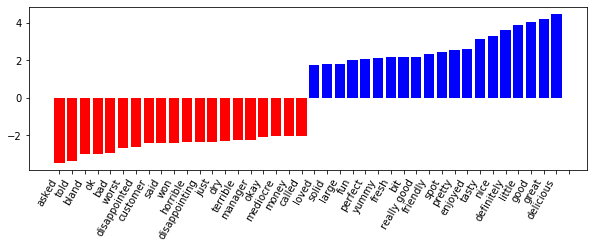

5



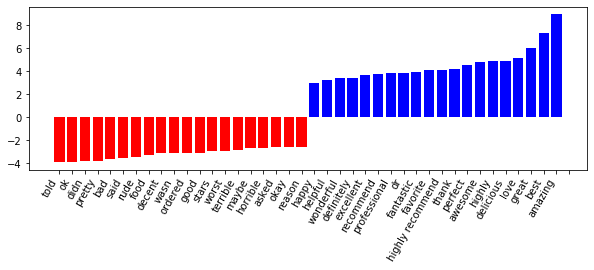

In [23]:
plot_coefficients(classifier, feature_names, 20)

# Demo

In [24]:
from ipywidgets import widgets
from IPython.display import display
text = widgets.Text()
display(text)
def handle_submit(sender):
    val = text.value
    balanced_x.append(val)
    vectors = vectorizer.fit_transform(balanced_x)
    preds = classifier.predict(vectors)
    print(preds[-1])
    
text.on_submit(handle_submit)

Text(value='')

### Exploration w/ Jaccard Similarity of Important Features 

In [25]:
tf

[array(['disgusting', 'paid', 'charged', 'bad', 'zero', 'waste', 'left',
        'customer', 'business', 'company', 'asked', 'called', 'said',
        'manager', 'rude', 'terrible', 'money', 'horrible', 'told',
        'worst'], dtype='<U66'),
 array(['barely', 'bad', 'unfortunately', 'average', 'meh', 'maybe',
        'okay', 'won', 'food', 'tasted', 'just', 'wasn', 'dry', 'ordered',
        'better', 'mediocre', 'ok', 'disappointing', 'disappointed',
        'bland'], dtype='<U66'),
 array(['selection', 'slow', 'really', 'little', 'probably', 'wasn',
        'average', 'nice', 'maybe', 'pretty good', 'quite', 'think',
        'okay', 'stars', 'overall', 'pretty', 'decent', 'ok', 'bit',
        'good'], dtype='<U66'),
 array(['loved', 'solid', 'large', 'fun', 'perfect', 'yummy', 'fresh',
        'bit', 'really good', 'friendly', 'spot', 'pretty', 'enjoyed',
        'tasty', 'nice', 'definitely', 'little', 'good', 'great',
        'delicious'], dtype='<U66'),
 array(['happy', 'helpful'

In [26]:
bf

[array(['great', 'good', 'delicious', 'friendly', 'nice', 'little',
        'amazing', 'love', 'pretty', 'best', 'really', 'definitely', 'bit',
        'stars', 'perfect', 'overall', 'awesome', 'happy', 'excellent',
        'tasty'], dtype='<U66'),
 array(['delicious', 'amazing', 'great', 'definitely', 'love', 'perfect',
        'fun', 'best', 'recommend', 'excellent', 'tasty', 'loved',
        'awesome', 'favorite', 'company', 'helpful', 'little', 'fantastic',
        'highly', 'enjoyed'], dtype='<U66'),
 array(['recommend', 'perfect', 'worst', 'told', 'amazing', 'going',
        'delicious', 'called', 'customer', 'highly', 'money', 'company',
        'horrible', 'manager', 'absolutely', 'terrible',
        'highly recommend', 'experience', 'best', 'care'], dtype='<U66'),
 array(['asked', 'told', 'bland', 'ok', 'bad', 'worst', 'disappointed',
        'customer', 'said', 'won', 'horrible', 'disappointing', 'just',
        'dry', 'terrible', 'manager', 'okay', 'mediocre', 'money',
     

In [27]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [28]:
for i in range(4):
    print(jaccard_similarity(tf[i], tf[i+1]))

0.02564102564102564
0.14285714285714285
0.14285714285714285
0.1111111111111111


In [29]:
for i in range(4):
    print(jaccard_similarity(bf[i], bf[i+1]))

0.3793103448275862
0.21212121212121213
0.25
0.2903225806451613


In [30]:
jaccard_similarity(bf[0], tf[4])

0.3333333333333333

In [31]:
jaccard_similarity(bf[4], tf[1])

0.21212121212121213

In [32]:
for i in [0, 1, 2, 3]:
    print(jaccard_similarity(tf[4], bf[i]))

0.3333333333333333
0.5384615384615384
0.21212121212121213
0.0


In [33]:
for i in [0, 1, 2, 4]:
    print(jaccard_similarity(tf[3], bf[i]))

0.3793103448275862
0.2903225806451613
0.05263157894736842
0.05263157894736842


In [34]:
for i in [0, 1, 3, 4]:
    print(jaccard_similarity(tf[2], bf[i]))

0.25
0.02564102564102564
0.05263157894736842
0.25


In [35]:
for i in [0, 2, 3, 4]:
    print(jaccard_similarity(tf[1], bf[i]))

0.0
0.0
0.3333333333333333
0.21212121212121213


In [36]:
for i in [1, 2, 3, 4]:
    print(jaccard_similarity(tf[0], bf[i]))

0.02564102564102564
0.2903225806451613
0.3793103448275862
0.25


In [37]:
feature_names

['00',
 '00 00',
 '00 05',
 '00 10',
 '00 100',
 '00 11',
 '00 12',
 '00 14',
 '00 15',
 '00 16oz',
 '00 20',
 '00 200',
 '00 25',
 '00 30',
 '00 30am',
 '00 45',
 '00 50',
 '00 ac',
 '00 added',
 '00 additional',
 '00 admission',
 '00 adults',
 '00 advised',
 '00 afternoon',
 '00 album',
 '00 allegiant',
 '00 american',
 '00 answer',
 '00 anyways',
 '00 appointment',
 '00 approximately',
 '00 array',
 '00 arrived',
 '00 ashley',
 '00 asked',
 '00 average',
 '00 avoue',
 '00 bacon',
 '00 based',
 '00 basic',
 '00 beat',
 '00 believe',
 '00 best',
 '00 beverages',
 '00 bites',
 '00 book',
 '00 books',
 '00 borscht',
 '00 bottle',
 '00 bottomless',
 '00 breakfast',
 '00 bring',
 '00 bucks',
 '00 buddy',
 '00 burger',
 '00 burgers',
 '00 busy',
 '00 buy',
 '00 called',
 '00 calls',
 '00 came',
 '00 camperworld',
 '00 cancellation',
 '00 card',
 '00 carne',
 '00 carpet',
 '00 ceasar',
 '00 chance',
 '00 change',
 '00 char',
 '00 charge',
 '00 charged',
 '00 cheese',
 '00 chicken',
 '00 chi

In [38]:
coef = classifier.coef_
coef[0]

array([ 1.94270904,  0.11142023,  0.04543641, ..., -0.01595429,
       -0.01595429, -0.01595429])

In [39]:
amazing = feature_names.index('amazing')

In [40]:
meh = feature_names.index('meh')

In [41]:
good = feature_names.index('good')

In [42]:
rude = feature_names.index('rude')

In [43]:
ok = feature_names.index('ok')

In [44]:
x_1 = []
y_1 = []
for i in range(5):
    x_1.append(i+1)
    y_1.append(coef[i][amazing])
    print(coef[i][amazing])
#plt.plot(x_1, y_1)

-3.982005827859427
-3.8079804508163693
-2.2501207814860904
-0.807893004820822
8.951251455004504


In [45]:
x_2 = []
y_2 = []
for i in range(5):
    x_2.append(i+1)
    y_2.append(coef[i][meh])
    print(coef[i][meh])
#plot(x_2, y_2);
#title('Importance of Meh');
#xlabel('Class');
#ylabel('Importance');
#show()

-0.6847935363483092
2.267456579770298
1.1185369668762912
-1.3358202653895839
-1.4379312600162724


In [46]:
x_3 = []
y_3 = []
for i in range(5):
    x_3.append(i+1)
    y_3.append(coef[i][good])
    print(coef[i][good])
#plt.plot(x_3, y_3)

-6.433946719871882
-0.7180376089922003
4.468029092457457
4.060752669728734
-3.0755738643675277


In [47]:
x_4 = []
y_4 = []
for i in range(5):
    x_4.append(i+1)
    y_4.append(coef[i][rude])
    print(coef[i][rude])
#plt.plot(x_4, y_4)

4.793586723893087
0.04889430211975244
-1.0798128841722745
-1.8610447445685263
-3.4883477438079398


### Tracing Word Importance over Star Classes

-1.4045053990327896
3.458280272245838
4.120748451145623
-2.991244260552694
-3.861407622436547


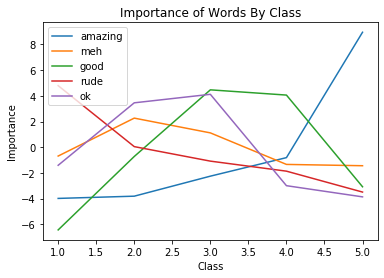

In [48]:
x_5 = []
y_5 = []
for i in range(5):
    x_5.append(i+1)
    y_5.append(coef[i][ok])
    print(coef[i][ok])
plot(x_1, y_1)
plot(x_2, y_2)
plot(x_3, y_3)
plot(x_4, y_4)
plot(x_5, y_5)
title("Importance of Words By Class");
ylabel("Importance");
xlabel("Class");
legend(['amazing','meh','good','rude','ok'])